## Cloud Mask Label Generation by Thresholding Band Values and Spectral Indices 

### Explored Features and Indices:
#### Raw TOA Reflectance Bands:
- Green Band (B2)
- Red Band (B3)
- NIR Band (B4)
#### Spectral Indices:
- NDVI (Normalized Difference Vegetation Index) = (NIR - Red) / (NIR + Red + 1e-6)
- BI (Brightness Index) = sqrt((Green^2 + Red^2 + NIR^2) / 3)
- PCI (Pseudo Cloud Index) = (Green + Red) / (NIR + 1e-6)
- GNDVI (Green NDVI) = (NIR - Green) / (NIR + Green + 1e-6)
- VNDI (Vegetation-NIR Difference Index) = (Green + Red - NIR) / ((Green + Red) + NIR + 1e-6)
- SI (Shadow Index) = (Green + Red) / (NIR + 1e-6)
- DPI (Dark Pixel Index) = 1 - ((Green + Red + NIR) / 3 * np.maximum.reduce([Green, Red, NIR]))
- NRGR (Normalized Red-Green Ratio) = NIR / (Green + Red + 1e-6)
- NIR_Ratio = NIR / (Red + 1e-6)
- HOT (Haze-Optimised Transformation) = Green - 0.5 * Red

### Labeling Strategy:
- Each image was processed independently.
- Different combinations of indices and thresholds were applied depending on the cloud cover characteristics, reflectance distribution, and contrast with land/water/vegetation.
- These thresholds were tuned per image based on visual inspection and histogram analysis of reflectance and index values.

In [1]:
import numpy as np
import rasterio
import pandas as pd
import os
from datetime import datetime
from rasterio.windows import Window
import matplotlib.pyplot as plt

In [2]:
# ------------------ Constants ------------------ #
DN_MAX = 1023.0
Lmax = {"B2": 52.0, "B3": 47.0, "B4": 31.5}
Lmin = {"B2": 0.0, "B3": 0.0, "B4": 0.0}
Esun = {"B2": 185.347, "B3": 158.262, "B4": 110.81}

# ------------------ TOA Reflectance ------------------ #
def get_solar_geometry(meta_path, excel_path):
    with open(meta_path, 'r') as f:
        for line in f:
            if 'DateOfPass' in line:
                date_of_pass = line.split('=')[1].strip()
            elif 'SunElevationAtCenter' in line:
                sun_elev = float(line.split('=')[1].strip())
    doy = datetime.strptime(date_of_pass, '%d-%b-%Y').timetuple().tm_yday
    df = pd.read_excel(excel_path)
    earth_sun_dist = float(df[df['DOY'] == doy].iloc[0]['d'])
    return sun_elev, earth_sun_dist

def compute_toa(dn, band_name, sun_elev, d):
    radiance = Lmin[band_name] + (dn / DN_MAX) * (Lmax[band_name] - Lmin[band_name])
    theta_s_rad = np.deg2rad(90 - sun_elev)
    return (np.pi * radiance * d**2) / (Esun[band_name] * np.cos(theta_s_rad))

# ------------------ Index Calculation ------------------ #
def calculate_indices(B2, B3, B4):
    NDVI = (B4 - B3) / (B4 + B3 + 1e-6)
    BI = np.sqrt((B2**2 + B3**2 + B4**2) / 3)
    PCI = (B2 + B3) / (B4 + 1e-6)
    GNDVI = (B4 - B2) / (B4 + B2 + 1e-6)
    VNDI = (B2 + B3 - B4) / ((B2 + B3) + B4 + 1e-6)
    SI = (B2 + B3) / (B4 + 1e-6)
    DPI = 1 - ((B2 + B3 + B4) / 3 * np.maximum.reduce([B2, B3, B4]))
    NRGR = B4 / (B2 + B3 + 1e-6)
    NIR_Ratio = B4 / (B3 + 1e-6)
    HOT = B2 - 0.5 * B3

    return {
        "NDVI": NDVI, 
        "BI": BI, 
        "PCI": PCI,
        "GNDVI": GNDVI, 
        "VNDI": VNDI,
        "SI": SI, 
        "DPI": DPI, 
        "NRGR": NRGR,
        "NIR_Ratio": NIR_Ratio,
        "HOT": HOT,
        "Green": B2,
        "Red": B3,
        "NIR": B4
    }

In [3]:
### For Example 1 ###

# ------------------ Thresholding logic to get the cloud mask ------------------ #
def create_mask_1(indices):
    BI = indices["BI"]
    NDVI = indices["NDVI"]
    PCI = indices["PCI"]  

    mask = ((NDVI < 0.4) & (BI > 12) & (PCI > 1.2)).astype(np.uint8)
    return mask

### For Example 2 ###

# ------------------ Thresholding logic to get the cloud mask ------------------ #
def create_mask_2(indices):
    BI = indices["BI"]
    NDVI = indices["NDVI"]
    PCI = indices["PCI"]
    NIR_Ratio = indices["NIR_Ratio"]  

    mask = (((BI > 13) & (NDVI < 0.5) & (PCI > 1.1)) |
            ((NIR_Ratio < 1.2) & (BI > 10))
           ).astype(np.uint8)
    return mask

### For Example 3 ###

# ------------------ Thresholding logic to get the cloud mask ------------------ #
def create_mask_3(indices):
    Green = indices["Green"]
    Red = indices["Red"]
    NIR = indices["NIR"]

    mask = (((Green >0.37) | (Red>0.32) | (NIR>0.39)) & (Red!=0)).astype(np.uint8)
    return mask


In [4]:
# ------------------ Main Pipeline ------------------ #
def generate_cloud_mask(band_paths, output_mask_path, mask_fn, use_toa=False, meta_path=None, excel_path=None):
    B2_src = rasterio.open(band_paths['B2'])
    B3_src = rasterio.open(band_paths['B3'])
    B4_src = rasterio.open(band_paths['B4'])

    profile = B2_src.profile
    profile.update({
        "dtype": rasterio.uint8,
        "count": 1,
        "compress": "lzw",  
        "driver": "GTiff",
        "nodata": 0
    })


    if use_toa:
        sun_elev, d = get_solar_geometry(meta_path, excel_path)
    else:
        sun_elev = d = None

    tile_size = 1024
    height, width = B2_src.height, B2_src.width

    with rasterio.open(output_mask_path, 'w', **profile) as dst:
        for i in range(0, height, tile_size):
            for j in range(0, width, tile_size):
                win_h = min(tile_size, height - i)
                win_w = min(tile_size, width - j)
                window = Window(j, i, win_w, win_h)

                B2 = B2_src.read(1, window=window).astype(np.float32)
                B3 = B3_src.read(1, window=window).astype(np.float32)
                B4 = B4_src.read(1, window=window).astype(np.float32)

                if use_toa:
                    B2 = compute_toa(B2, "B2", sun_elev, d)
                    B3 = compute_toa(B3, "B3", sun_elev, d)
                    B4 = compute_toa(B4, "B4", sun_elev, d)
                else:
                    B2 = (B2 / DN_MAX) * Lmax["B2"]
                    B3 = (B3 / DN_MAX) * Lmax["B3"]
                    B4 = (B4 / DN_MAX) * Lmax["B4"]

                indices = calculate_indices(B2, B3, B4)
                mask = mask_fn(indices)

                dst.write(mask, 1, window=window)

    B2_src.close()
    B3_src.close()
    B4_src.close()
    print(f"✅ Cloud mask saved to {output_mask_path}")

In [ ]:
# ------------------ Histograms for some Indices ------------------ #
def analyze_indices(indices, example_id):
    keys = ["NDVI", "BI", "PCI", "HOT", "NIR_Ratio"]
    plt.figure(figsize=(15, 10))
    
    for i, key in enumerate(keys, 1):
        plt.subplot(2, 3, i)
        data = indices[key]

        # Mask invalid or near-zero values
        valid_data = data[np.isfinite(data) & (data > 1e-3)]

        plt.hist(valid_data.ravel(), bins=100, density=True,
                 color='orange', edgecolor='black')
        plt.title(f"{key} Distribution")
        plt.xlabel(key)
        plt.ylabel("Density")

    plt.suptitle(f"Histograms for some indices (Example {example_id})", fontsize=14)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


In [7]:
# ------------------ Example 1 ------------------ #
band_paths = {
    "B2": r"D:\NRSC\BH_RAF16SEP2024040353009000054SSANSTUC00GTDA\BAND2.tif",
    "B3": r"D:\NRSC\BH_RAF16SEP2024040353009000054SSANSTUC00GTDA\BAND3.tif",
    "B4": r"D:\NRSC\BH_RAF16SEP2024040353009000054SSANSTUC00GTDA\BAND4.tif"
}

generate_cloud_mask(
    band_paths=band_paths,
    output_mask_path="cloud_mask_1.tif",
    mask_fn=create_mask_1,
    use_toa=False,  
    meta_path=r"D:\NRSC\BH_RAF16SEP2024040353009000054SSANSTUC00GTDA\BAND_META.txt",
    excel_path=r"D:\NRSC\Earth_Sun_distance.xlsx"
)


✅ Cloud mask saved to cloud_mask_1.tif


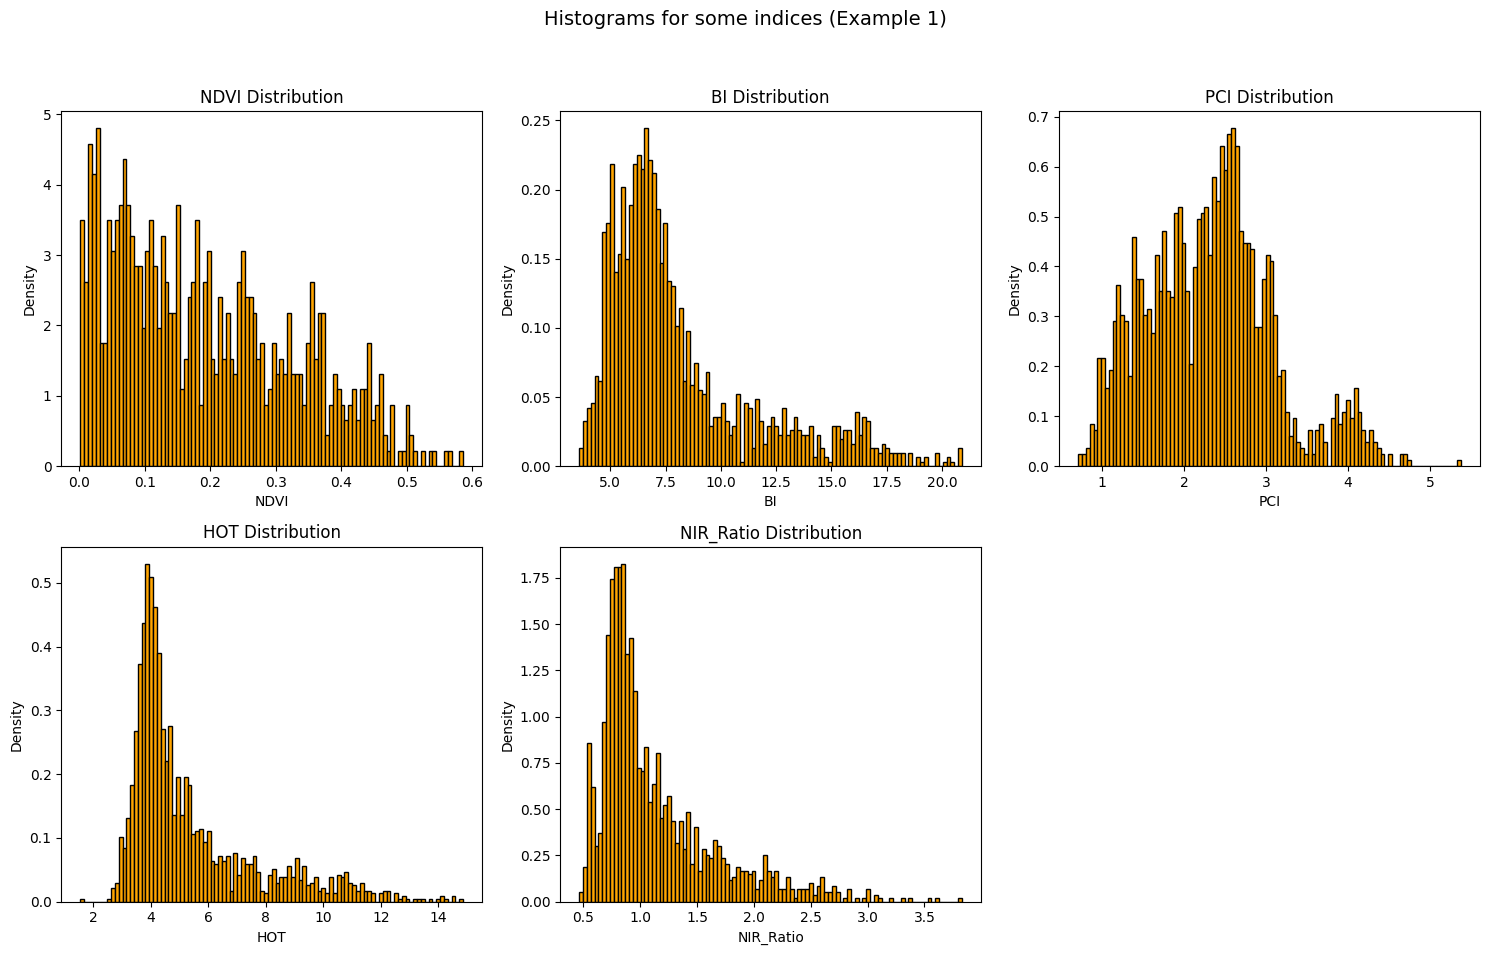

In [15]:
# ----------- Indices Histogram (Example 1) -------------- #
with rasterio.open(band_paths['B2']) as src:
    B2 = src.read(1, out_shape=(1, src.height//8, src.width//8)).astype(np.float32)[0]
with rasterio.open(band_paths['B3']) as src:
    B3 = src.read(1, out_shape=(1, src.height//8, src.width//8)).astype(np.float32)[0]
with rasterio.open(band_paths['B4']) as src:
    B4 = src.read(1, out_shape=(1, src.height//8, src.width//8)).astype(np.float32)[0]

B2 = (B2 / DN_MAX) * Lmax["B2"]
B3 = (B3 / DN_MAX) * Lmax["B3"]
B4 = (B4 / DN_MAX) * Lmax["B4"]

indices = calculate_indices(B2, B3, B4)
analyze_indices(indices, 1)

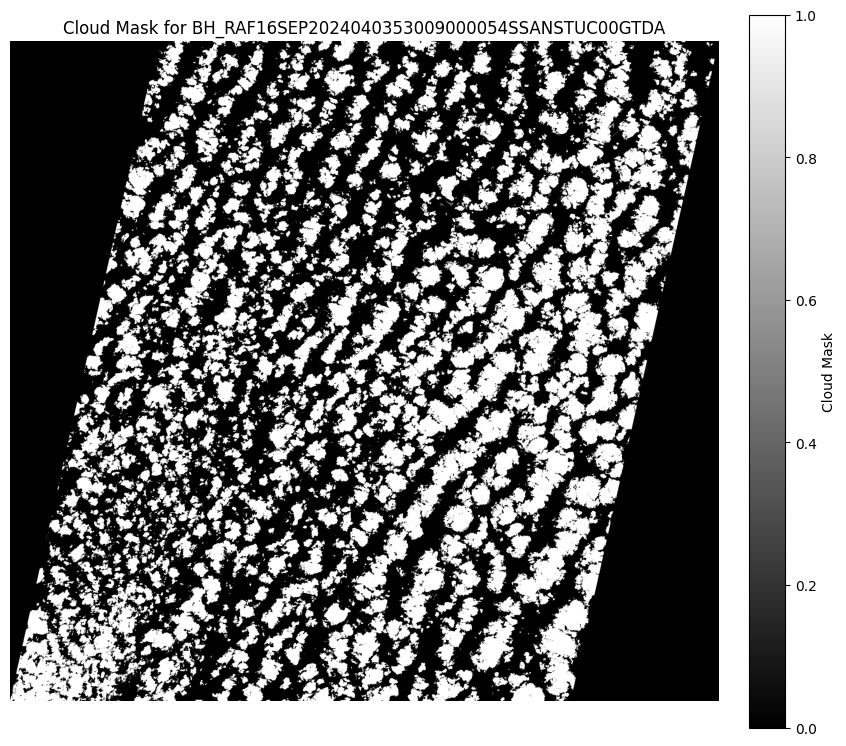

In [10]:
with rasterio.open('cloud_mask_1.tif') as src:
    # 8x downsampling while reading
    mask = src.read(
        out_shape=(1, src.height // 8, src.width // 8)
    )[0]

plt.figure(figsize=(10,10))
img = plt.imshow(mask, cmap='gray')
plt.title("Cloud Mask for BH_RAF16SEP2024040353009000054SSANSTUC00GTDA")
plt.axis('off')
plt.colorbar(img, fraction=0.046, pad=0.04, label='Cloud Mask')
plt.show()

In [12]:
# ------------------ Example 2 ------------------ #
band_paths = {
    "B2": r"D:\NRSC\BH_RAF19JUL2024039514010700054SSANSTUC00GTDD\BAND2.tif",
    "B3": r"D:\NRSC\BH_RAF19JUL2024039514010700054SSANSTUC00GTDD\BAND3.tif",
    "B4": r"D:\NRSC\BH_RAF19JUL2024039514010700054SSANSTUC00GTDD\BAND4.tif"
}

generate_cloud_mask(
    band_paths=band_paths,
    output_mask_path="cloud_mask_2.tif",
    mask_fn=create_mask_2,
    use_toa=False,  
    meta_path=r"D:\NRSC\BH_RAF19JUL2024039514010700054SSANSTUC00GTDD\BAND_META.txt",
    excel_path=r"D:\NRSC\Earth_Sun_distance.xlsx"
)

✅ Cloud mask saved to cloud_mask_2.tif


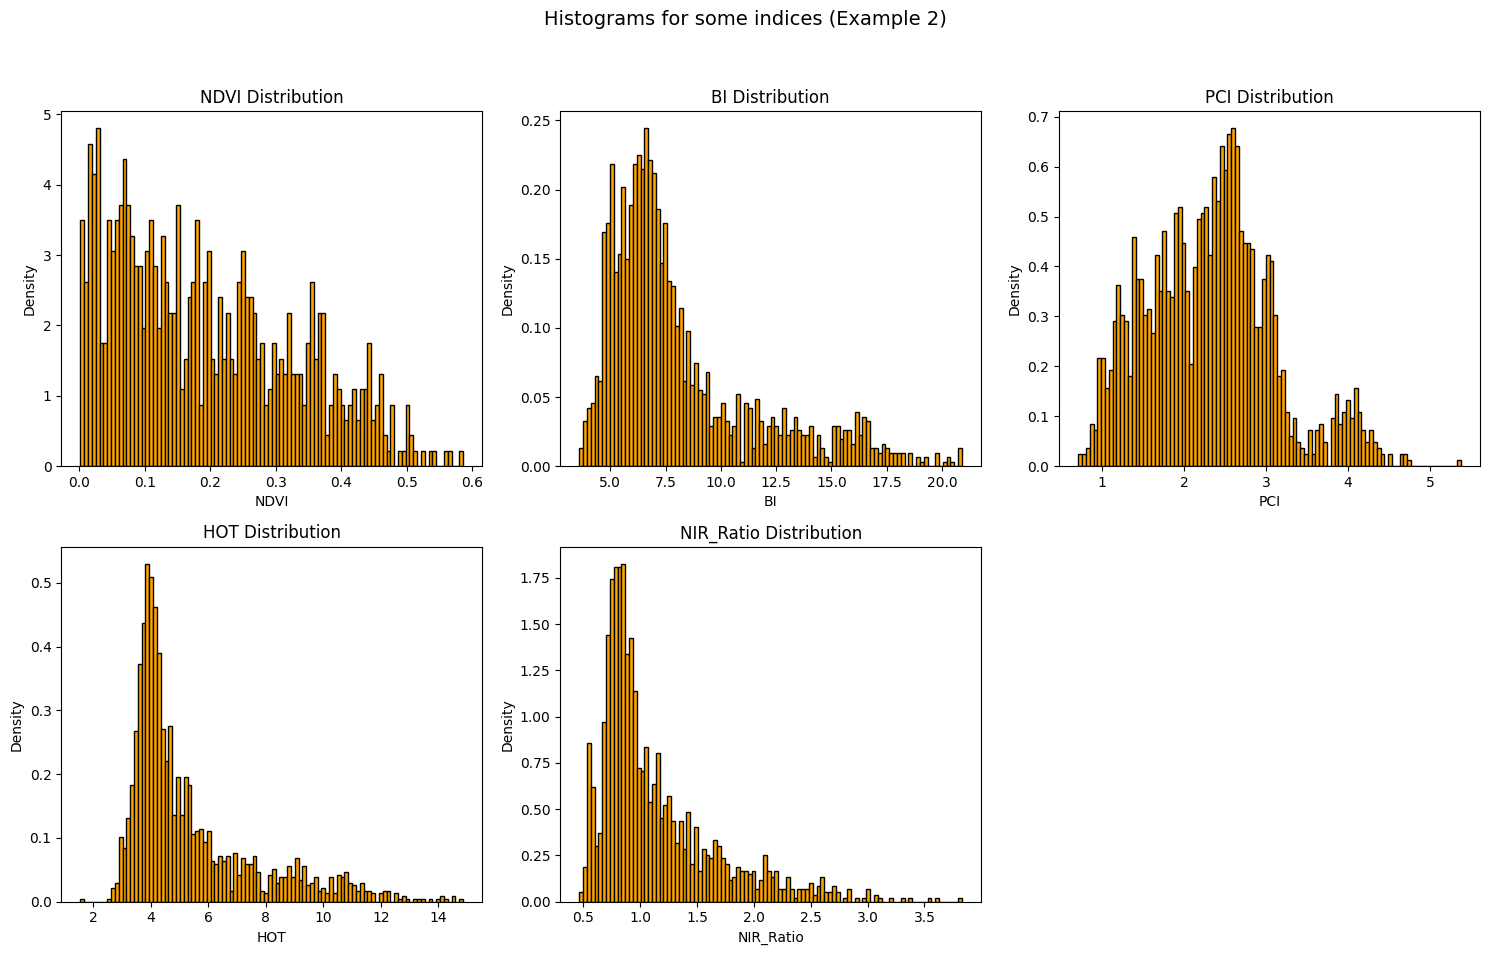

In [16]:
# ----------- Indices Histogram (Example 2) -------------- #
with rasterio.open(band_paths['B2']) as src:
    B2 = src.read(1, out_shape=(1, src.height//8, src.width//8)).astype(np.float32)[0]
with rasterio.open(band_paths['B3']) as src:
    B3 = src.read(1, out_shape=(1, src.height//8, src.width//8)).astype(np.float32)[0]
with rasterio.open(band_paths['B4']) as src:
    B4 = src.read(1, out_shape=(1, src.height//8, src.width//8)).astype(np.float32)[0]

B2 = (B2 / DN_MAX) * Lmax["B2"]
B3 = (B3 / DN_MAX) * Lmax["B3"]
B4 = (B4 / DN_MAX) * Lmax["B4"]

indices = calculate_indices(B2, B3, B4)
analyze_indices(indices, 2)

In [17]:
with rasterio.open('cloud_mask_2.tif') as src:
    # 8x downsampling while reading
    mask = src.read(
        out_shape=(1, src.height // 8, src.width // 8)
    )[0]

plt.figure(figsize=(10,10))
img = plt.imshow(mask, cmap='gray')
plt.title("Cloud Mask for BH_RAF19JUL2024039514010700054SSANSTUC00GTDD")
plt.axis('off')
plt.colorbar(img, fraction=0.046, pad=0.04, label='Cloud Mask')
plt.show()

In [18]:
# ------------------ Example 3 ------------------ #
band_paths = {
    "B2": r"D:\NRSC\BH_RAF22JUN2024039131009200052SSANSTUC00GTDA\BAND2.tif",
    "B3": r"D:\NRSC\BH_RAF22JUN2024039131009200052SSANSTUC00GTDA\BAND3.tif",
    "B4": r"D:\NRSC\BH_RAF22JUN2024039131009200052SSANSTUC00GTDA\BAND4.tif"
}

generate_cloud_mask(
    band_paths=band_paths,
    output_mask_path="cloud_mask_3.tif",
    mask_fn=create_mask_3,
    use_toa=True,  
    meta_path=r"D:\NRSC\BH_RAF22JUN2024039131009200052SSANSTUC00GTDA\BAND_META.txt",
    excel_path=r"D:\NRSC\Earth_Sun_distance.xlsx"
)

✅ Cloud mask saved to cloud_mask_3.tif


In [19]:
# ----------- TOA + Indices Histograms (Example 3) -------------- #
with rasterio.open(band_paths['B2']) as src:
    B2 = src.read(1, out_shape=(1, src.height//8, src.width//8)).astype(np.float32)[0]
with rasterio.open(band_paths['B3']) as src:
    B3 = src.read(1, out_shape=(1, src.height//8, src.width//8)).astype(np.float32)[0]
with rasterio.open(band_paths['B4']) as src:
    B4 = src.read(1, out_shape=(1, src.height//8, src.width//8)).astype(np.float32)[0]

sun_elev, d = get_solar_geometry(
    meta_path=r"D:\NRSC\BH_RAF22JUN2024039131009200052SSANSTUC00GTDA\BAND_META.txt",
    excel_path=r"D:\NRSC\Earth_Sun_distance.xlsx"
)

B2_toa = compute_toa(B2, "B2", sun_elev, d)
B3_toa = compute_toa(B3, "B3", sun_elev, d)
B4_toa = compute_toa(B4, "B4", sun_elev, d)

# Plotting TOA Reflectance Histograms #
plt.figure(figsize=(15, 5))

for i, (name, data) in enumerate(zip(['Green (B2)', 'Red (B3)', 'NIR (B4)'], [B2_toa, B3_toa, B4_toa]), 1):
    plt.subplot(1, 3, i)
    plt.hist(data[data > 0].ravel(), bins=100, color='skyblue', edgecolor='black')
    plt.title(f"TOA Histogram - {name}")
    plt.xlabel("Reflectance")
    plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

# Plotting histograms for some indices ("NDVI", "BI", "PCI", "HOT", "NIR_Ratio")
indices = calculate_indices(B2_toa, B3_toa, B4_toa)
analyze_indices(indices, 3)

In [20]:
with rasterio.open('cloud_mask_3.tif') as src:
    # 8x downsampling while reading
    mask = src.read(
        out_shape=(1, src.height // 8, src.width // 8)
    )[0]

plt.figure(figsize=(10,10))
img = plt.imshow(mask, cmap='gray')
plt.title("Cloud Mask for BH_RAF22JUN2024039131009200052SSANSTUC00GTDA")
plt.axis('off')
plt.colorbar(img, fraction=0.046, pad=0.04, label='Cloud Mask')
plt.show()